In [1]:
#Trying to solve the flower classification from kaggle using Pytorch,It has 5 folders each having one type of flower
#https://www.kaggle.com/alxmamaev/flowers-recognition
#First load from the drive through mount or using folder
#It has a parent folder and 5 sub folders

#to load this completely in a dataloader considering the entire thing as training set,Then we need to load the the data to the torchvision.datasets.ImageFolder
#This will take the targets automatically from the folder hierarchy here each flower set as (0,1,2,3,4) classes

#we must convert to tensor using transform and in this case that was alone not enough, we need to normalize too 
'''trans = transforms.Compose([transforms.RandomRotation(25),
                              transforms.RandomResizedCrop(224),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

data_dir = '/content/drive/MyDrive/Flowers/flowers'
dataset = torchvision.datasets.ImageFolder(data_dir,transform=trans)
train_loader=torch.utils.data.DataLoader(dataset,batch_size=64,num_workers=0,shuffle=True)

for data,target in train_loader:
  print(target)'''

"trans = transforms.Compose([transforms.RandomRotation(25),\n                              transforms.RandomResizedCrop(224),\n                              transforms.RandomHorizontalFlip(),\n                              transforms.ToTensor(),\n                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])\n\ndata_dir = '/content/drive/MyDrive/Flowers/flowers'\ndataset = torchvision.datasets.ImageFolder(data_dir,transform=trans)\ntrain_loader=torch.utils.data.DataLoader(dataset,batch_size=64,num_workers=0,shuffle=True)\n\nfor data,target in train_loader:\n  print(target)"

In [2]:
#But here we need to split the folders to train,validation and then load to loaders

In [19]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


In [4]:
#transformations to be done for the images
trans = transforms.Compose([transforms.RandomResizedCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])



In [5]:
#https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987
#specify the path and import data
data_dir = '/content/drive/MyDrive/Flowers/flowers'
dataset = torchvision.datasets.ImageFolder(data_dir,transform=trans)
print(len(dataset))

4323


In [6]:
#now we need to split to train and test sets
#we can use the inbuilt Random.split method
#train_set, val_set = torch.utils.data.random_split(dataset, [3000, 1323]) we can try the below method using torch.utils.data.Subset

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['val'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets

datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)



3242
1081
Dataset ImageFolder
    Number of datapoints: 4323
    Root location: /content/drive/MyDrive/Flowers/flowers
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [7]:
batch_size=4
num_classes=5
#Now we can load to loaders
train_loader=torch.utils.data.DataLoader(datasets['train'],batch_size=batch_size,num_workers=0,shuffle=True)
test_loader=torch.utils.data.DataLoader(datasets['val'],batch_size=batch_size,num_workers=0)

x,y = next(iter(train_loader))
print(x.shape, y.shape)

x,y = next(iter(test_loader))
print(x.shape, y.shape)

torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([4, 3, 224, 224]) torch.Size([4])


In [8]:
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
def imshow(img, title):
    #de normalization
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [10]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


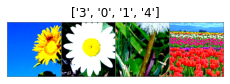

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


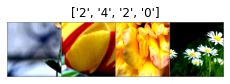

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


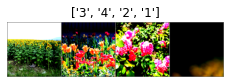

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


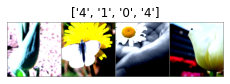

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


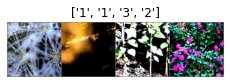

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


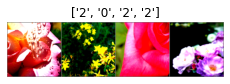

In [14]:
for i in range(6):
    show_batch_images(train_loader)

In [15]:
from torchvision import models

In [24]:
vgg=models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [25]:
#now freeze the parameters from updating 
for param in vgg.parameters():
  param.requires_grad=False
  

In [27]:
#changing the last layer alone by deleting that last layer and adding a new layer and letting that alone for weight updation by setting requires_grad true
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,num_classes)

In [29]:
#we can check the above
for param in vgg.parameters():
  if param.requires_grad==True:
    print(param.shape)

torch.Size([5, 4096])
torch.Size([5])


In [37]:
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(vgg.parameters(),lr=0.01)

In [33]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Iteration: 0/1081, Loss: 1.42
Iteration: 100/1081, Loss: 0.48
Iteration: 200/1081, Loss: 0.03
Iteration: 300/1081, Loss: 0.46
Iteration: 400/1081, Loss: 1.19
Iteration: 500/1081, Loss: 0.01
Iteration: 600/1081, Loss: 4.98
Iteration: 700/1081, Loss: 0.61
Iteration: 800/1081, Loss: 2.50
Epoch: 0/10, Test acc: 70.95, Train acc: 71.25
Iteration: 0/1081, Loss: 2.29
Iteration: 100/1081, Loss: 0.28
Iteration: 200/1081, Loss: 0.11
Iteration: 300/1081, Loss: 4.00
Iteration: 400/1081, Loss: 0.62
Iteration: 500/1081, Loss: 0.60
Iteration: 600/1081, Loss: 2.78
Iteration: 700/1081, Loss: 0.76
Iteration: 800/1081, Loss: 3.72
Epoch: 1/10, Test acc: 68.64, Train acc: 69.65
Iteration: 0/1081, Loss: 1.73
Iteration: 100/1081, Loss: 1.80
Iteration: 200/1081, Loss: 6.65
Iteration: 300/1081, Loss: 2.20
Iteration: 400/1081, Loss: 5.49
Iteration: 500/1081, Loss: 2.76
Iteration: 600/1081, Loss: 2.72
Iteration: 700/1081, Loss: 0.07
Iteration: 800/1081, Loss: 1.41
Epoch: 2/10, Test acc: 71.97, Train acc: 70.79
I

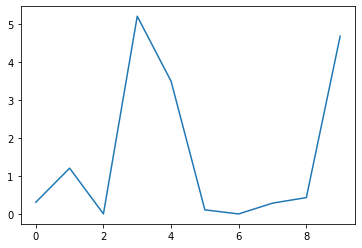

In [38]:
loss_epoch_arr = []
max_epochs = 10

n_iters = np.ceil(4323/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(test_loader, vgg), evaluation(train_loader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()